# Modelagem Preditiva de Séries Temporais - Em Python

# <font color='blue'>Deep Learning - Recurrent Neural Networks (RNN)</font>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

# Prevendo Séries Temporais com Stacked LSTMs 

Finalmente, vejamos um dos maiores benefícios das LSTMs, o fato de que elas podem ser treinadas com sucesso quando empilhadas em arquiteturas de redes profundas. As redes LSTM podem ser empilhadas em Keras da mesma maneira que outros tipos de camada podem ser empilhadas. Uma adição é que a camada LSTM anterior a cada camada LSTM subsequente, deve retornar a sequência. Isso pode ser feito configurando o parâmetro return_sequences = True na camada 1. 

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
# Importa TF2
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
# Imports
import math
import numpy
import pandas as pd
import os
import io
import requests

from pandas.tseries.offsets import DateOffset

# Importa Keras TF2
from tensorflow import keras   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from time import time
from datetime import datetime

In [3]:
# Função Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [40]:
# Função Carrega os dados
def carrega_dados():

    # Carrega os dataframe
    dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
    dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
    dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
    dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
    dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                          'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

    # Carregando os dados
    # Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
    # pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
    # carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
    # com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
    # Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

    datasetfull = dataframe.copy()

    filtro1 = datasetfull['Broker']=='ETB170'
    filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
    filtro3 = datasetfull['Programa']=='NSDGX500'
    datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

    datasetfull = datasetfull.rename_axis('index').reset_index()
    datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

    # Remove as linhas com as datas duplicadas
    # Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
    # inclui dados missing com a interpolação 

    datasetfull.drop_duplicates(subset='Data', inplace=True)
    datasetfull = datasetfull.set_index('Data')
    datasetfull = datasetfull.resample('D').interpolate()

    return datasetfull

In [5]:
# Função Split em treino e teste
def split_train_test(datasetfull):
    train_size = int(len(datasetfull) * 0.75)
    test_size = len(datasetfull) - train_size
    dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]
    return dataset, test

In [6]:
# Função Split em treino e validação
def split_train_test_valid(train_set):
    train_size = int(len(dataset) * 0.67)
    valid_size = len(dataset) - train_size
    train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, valid 

In [7]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 10

# Cria o objeto scaler no intervalo [0, 1]
# usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))

Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

In [8]:
# Carrega os dados
datasetfull = carrega_dados()
    
datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

In [9]:
# Split em treino e teste
dataset, test = split_train_test(datasetfull)

In [10]:
# Função Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. 

dataset = scaler.fit_transform(dataset)

In [11]:
# Split em treino e validação
train, valid = split_train_test_valid(dataset)

In [12]:
dataset.shape

(273, 1)

In [13]:
train.shape

(182, 1)

In [14]:
valid.shape

(91, 1)

In [15]:
test.shape

(92, 1)

In [16]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [17]:
# Cria o modelo LSTM
batch_size = 1

model = Sequential()
model.add(LSTM(100, batch_input_shape = (batch_size, look_back, 1), activation = 'tanh', return_sequences = True))
model.add(LSTM(50, activation = 'tanh', return_sequences = True))
model.add(LSTM(20,  activation = 'tanh'))
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(5, activation = 'tanh'))
model.add(Dense(1))
    
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [65]:
# Cria o modelo LSTM
batch_size = 1

model = Sequential()
model.add(LSTM(200, batch_input_shape = (batch_size, look_back, 1), activation = 'tanh', return_sequences = True))
model.add(LSTM(100, activation = 'tanh', return_sequences = True))
model.add(LSTM(50,  activation = 'tanh', return_sequences = True))
model.add(LSTM(25,  activation = 'tanh'))
model.add(Dense(20, activation = 'tanh'))
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(1))
    
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10, 100)              40800     
                                                                 
 lstm_1 (LSTM)               (1, 10, 50)               30200     
                                                                 
 lstm_2 (LSTM)               (1, 20)                   5680      
                                                                 
 dense (Dense)               (1, 10)                   210       
                                                                 
 dense_1 (Dense)             (1, 5)                    55        
                                                                 
 dense_2 (Dense)             (1, 1)                    6         
                                                                 
Total params: 76,951
Trainable params: 76,951
Non-traina

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (1, 10, 200)              161600    
                                                                 
 lstm_4 (LSTM)               (1, 10, 100)              120400    
                                                                 
 lstm_5 (LSTM)               (1, 10, 50)               30200     
                                                                 
 lstm_6 (LSTM)               (1, 25)                   7600      
                                                                 
 dense_3 (Dense)             (1, 20)                   520       
                                                                 
 dense_4 (Dense)             (1, 10)                   210       
                                                                 
 dense_5 (Dense)             (1, 1)                   

In [19]:
# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

for i in range(300):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False)
    model.reset_states()
    
current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 22:39:24
171/171 [==============================] - 3s 15ms/step - loss: 0.0020


171/171 [==============================] - 2s 14ms/step - loss: 2.7609e-05


171/171 [==============================] - 3s 15ms/step - loss: 1.0097e-05

Hora de Término = 22:52:21
Tempo gasto: 777.0386958122253 segundos


In [ ]:
# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

for i in range(300):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False)
    model.reset_states()
    
current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 23:43:02
171/171 [==============================] - 3s 18ms/step - loss: 0.0361


 43/171 [======>.......................] - ETA: 2s - loss: 0.0325

In [20]:
#trainX

In [21]:
#trainY

In [22]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stacked.h5"))

## Agora recarregamos o modelo para realizamos uma previsão.

In [23]:
# Carrega os dados
datasetfull = carrega_dados()
    
datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
dataset, test = split_train_test(datasetfull)

dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train, valid = split_train_test_valid(dataset)

In [24]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [25]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stacked.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10, 100)              40800     
                                                                 
 lstm_1 (LSTM)               (1, 10, 50)               30200     
                                                                 
 lstm_2 (LSTM)               (1, 20)                   5680      
                                                                 
 dense (Dense)               (1, 10)                   210       
                                                                 
 dense_1 (Dense)             (1, 5)                    55        
                                                                 
 dense_2 (Dense)             (1, 1)                    6         
                                                                 
Total params: 76,951
Trainable params: 76,951
Non-traina

In [26]:
# Previsões
batch_size = 1
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)

80/80 [==============================] - 1s 7ms/step


In [27]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [28]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 2.1089 RMSE
Score em Validação: 78.0692 RMSE


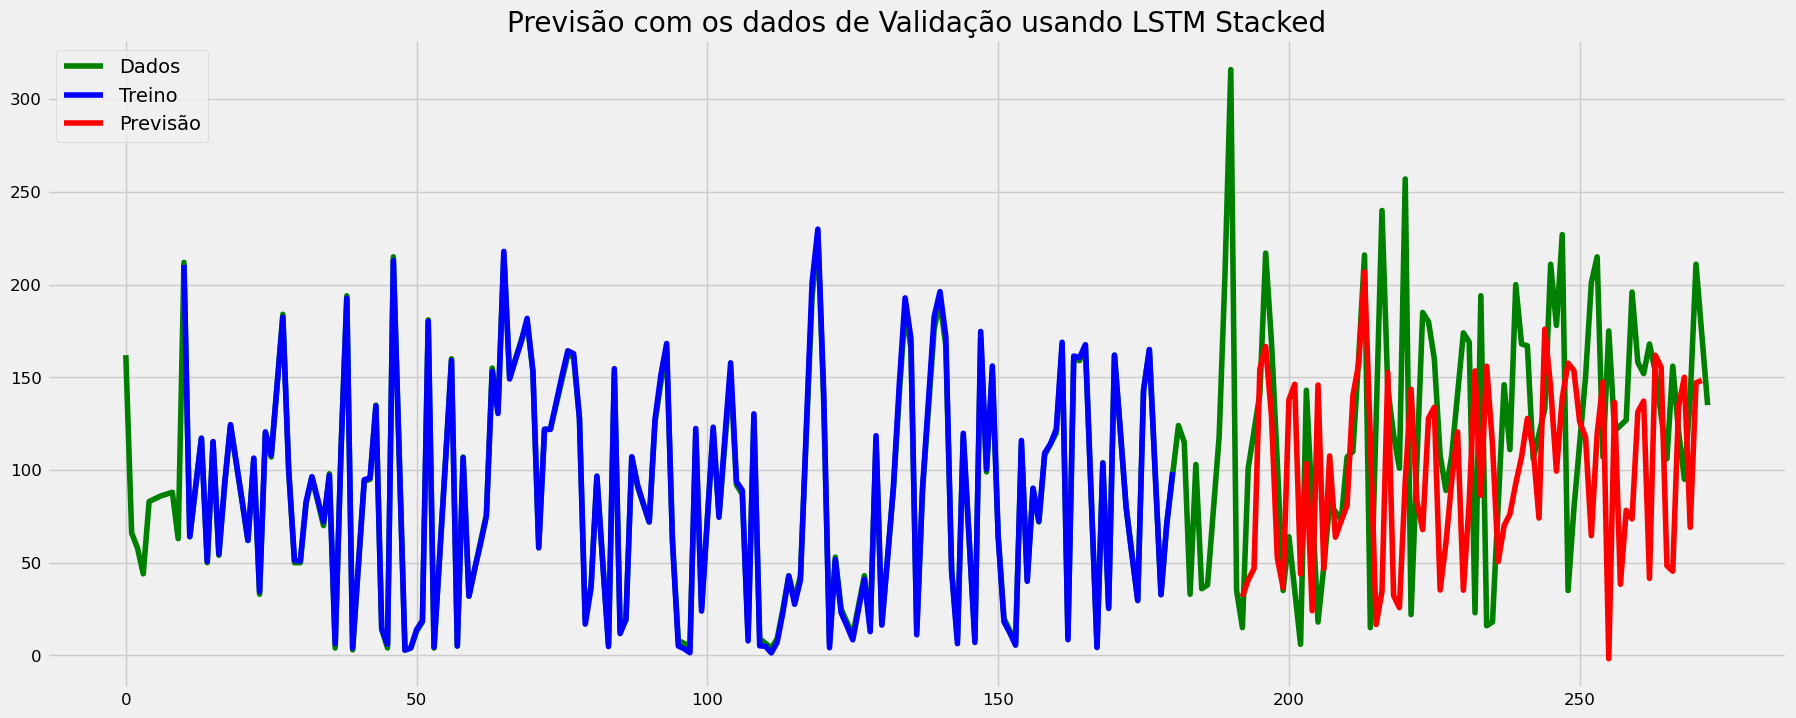

In [29]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stacked") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Treino')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

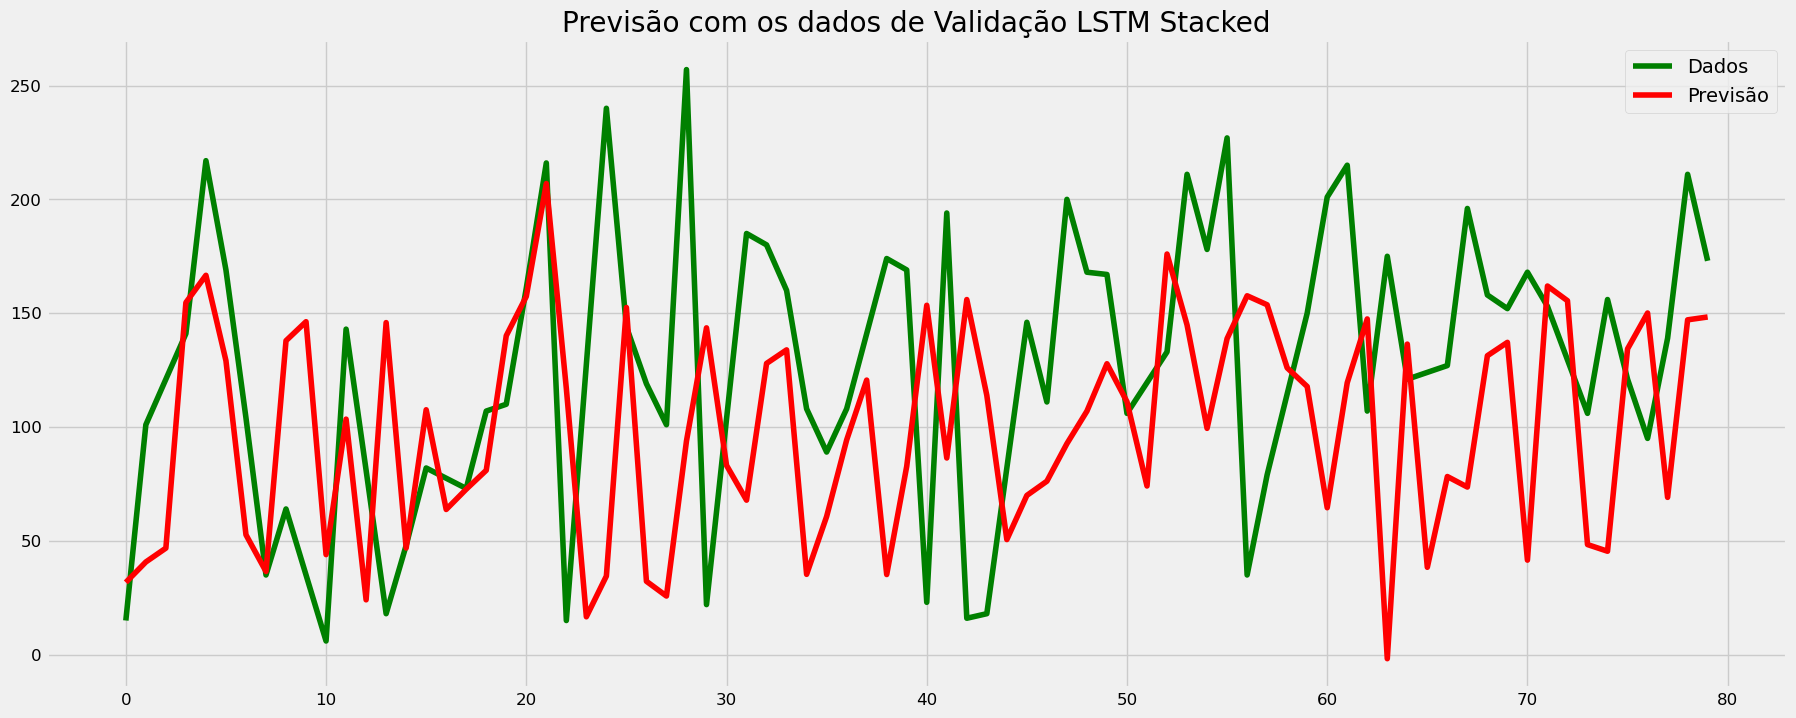

In [30]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stacked") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Vamos fazer o Forecasting para os dados de teste. 

In [42]:
# Carrega os dataframe

# Carrega os dados
datasetfull = carrega_dados()

target = datasetfull['Quantidade']

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Refinamos os dados para o gráfico da série original
# A variável Quantidade é nossa variável target 
raw_values = target.values

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [43]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stacked.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10, 100)              40800     
                                                                 
 lstm_1 (LSTM)               (1, 10, 50)               30200     
                                                                 
 lstm_2 (LSTM)               (1, 20)                   5680      
                                                                 
 dense (Dense)               (1, 10)                   210       
                                                                 
 dense_1 (Dense)             (1, 5)                    55        
                                                                 
 dense_2 (Dense)             (1, 1)                    6         
                                                                 
Total params: 76,951
Trainable params: 76,951
Non-traina

In [44]:
# Previsões com dados de Teste
#model.reset_states()
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

81/81 [==============================] - 1s 6ms/step


In [45]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [46]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 2.1089 RMSE
Score em Validação: 78.0692 RMSE
Score em Teste: 97.5789 RMSE


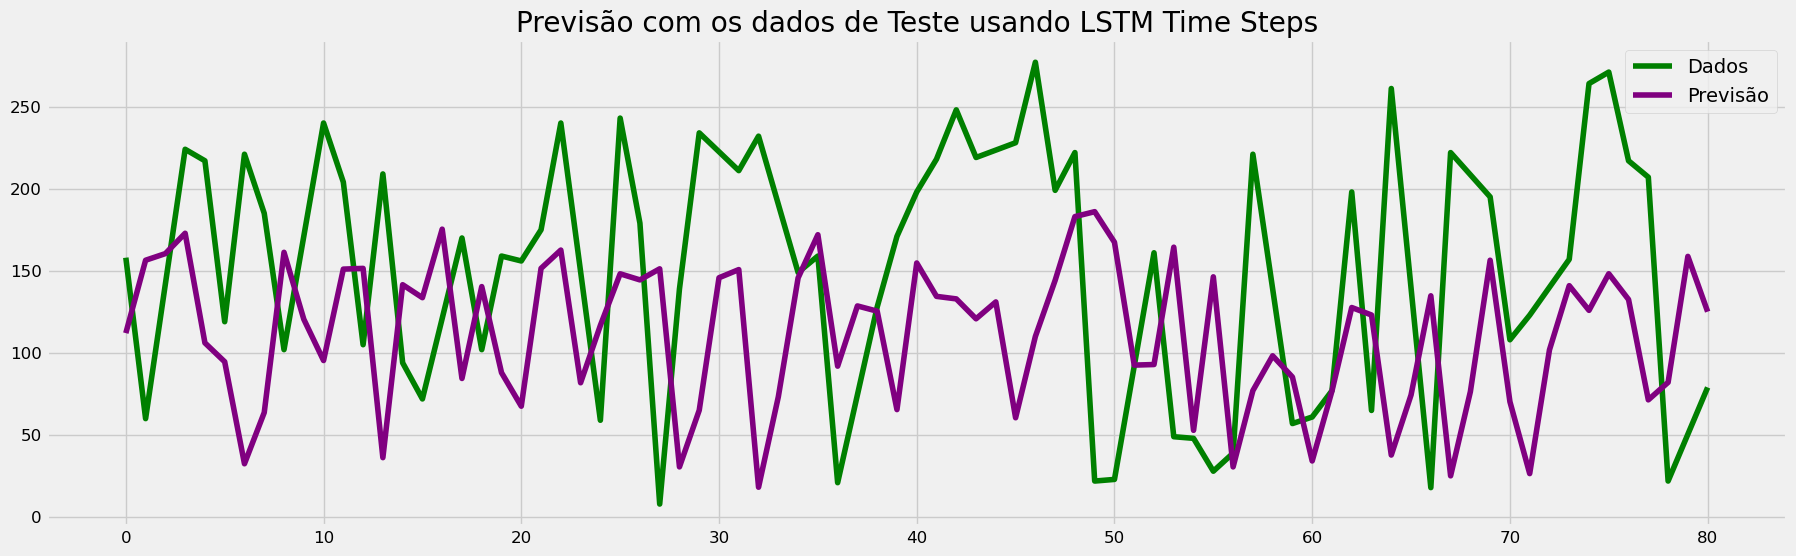

In [47]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Time Steps") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

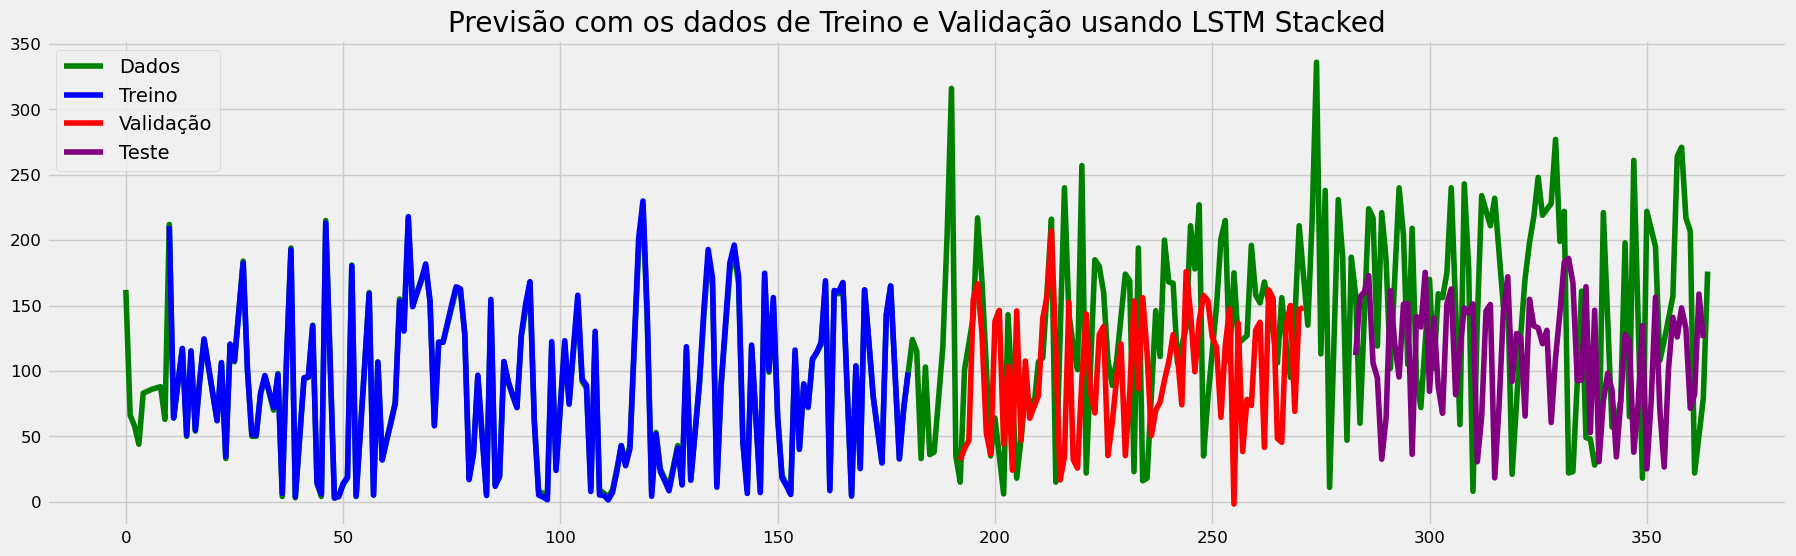

In [48]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict               

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(testPredict)+(look_back*2)+1:len(datasetfull)-1, :] = testPredict
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Stacked") 
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 82 dias de horizonte de previsão

In [50]:
# Carrega os dados
datasetfull = carrega_dados()

target = datasetfull['Quantidade']

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Refinamos os dados para o gráfico da série original
raw_values = target.values

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX1, trainY = create_dataset(train, look_back)
validX1, validY = create_dataset(valid, look_back)
testX1, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
validX = numpy.reshape(validX1, (validX1.shape[0], validX1.shape[1], 1))
testX = numpy.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

In [51]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stacked.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10, 100)              40800     
                                                                 
 lstm_1 (LSTM)               (1, 10, 50)               30200     
                                                                 
 lstm_2 (LSTM)               (1, 20)                   5680      
                                                                 
 dense (Dense)               (1, 10)                   210       
                                                                 
 dense_1 (Dense)             (1, 5)                    55        
                                                                 
 dense_2 (Dense)             (1, 1)                    6         
                                                                 
Total params: 76,951
Trainable params: 76,951
Non-traina

In [52]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back, 1)
    yhat = model.predict(X)
    yhat1 = scaler.inverse_transform(yhat)
    return yhat1[0,0]

In [53]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX1)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX1[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX1) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))
   

1/1 [==============================] - 1s 1s/step
Mês = 1, Valor Previsto = 102.301849, Valor Esperado = 96.000000
1/1 [==============================] - 0s 30ms/step
Mês = 2, Valor Previsto = 144.654190, Valor Esperado = 51.000000
1/1 [==============================] - 0s 31ms/step
Mês = 3, Valor Previsto = 148.510925, Valor Esperado = 6.000000
1/1 [==============================] - 0s 31ms/step
Mês = 4, Valor Previsto = 160.332520, Valor Esperado = 152.000000
1/1 [==============================] - 0s 32ms/step
Mês = 5, Valor Previsto = 96.638016, Valor Esperado = 13.000000
1/1 [==============================] - 0s 30ms/step
Mês = 6, Valor Previsto = 85.670059, Valor Esperado = 19.000000
1/1 [==============================] - 0s 31ms/step
Mês = 7, Valor Previsto = 26.401630, Valor Esperado = 107.000000
1/1 [==============================] - 0s 31ms/step
Mês = 8, Valor Previsto = 56.167046, Valor Esperado = 91.000000
1/1 [==============================] - 0s 31ms/step
Mês = 9, Valor Pr

1/1 [==============================] - 0s 31ms/step
Mês = 71, Valor Previsto = 62.474030, Valor Esperado = 20.000000
1/1 [==============================] - 0s 32ms/step
Mês = 72, Valor Previsto = 20.686703, Valor Esperado = 13.500000
1/1 [==============================] - 0s 34ms/step
Mês = 73, Valor Previsto = 92.575691, Valor Esperado = 7.000000
1/1 [==============================] - 0s 33ms/step
Mês = 74, Valor Previsto = 129.883926, Valor Esperado = 114.000000
1/1 [==============================] - 0s 33ms/step
Mês = 75, Valor Previsto = 115.540871, Valor Esperado = 41.000000
1/1 [==============================] - 0s 31ms/step
Mês = 76, Valor Previsto = 136.802277, Valor Esperado = 90.000000
1/1 [==============================] - 0s 32ms/step
Mês = 77, Valor Previsto = 121.826355, Valor Esperado = 72.000000
1/1 [==============================] - 0s 30ms/step
Mês = 78, Valor Previsto = 63.533371, Valor Esperado = 108.000000
1/1 [==============================] - 0s 33ms/step
Mês = 7

In [71]:
previsoes_lstm

[70.81416,
 108.1016,
 47.099873,
 52.978165,
 144.31056,
 100.72239,
 16.012545,
 90.25149,
 106.91894,
 44.434444,
 108.10296,
 138.2443,
 112.6079,
 20.290304,
 127.61633,
 76.7407,
 60.773346,
 116.72617,
 139.33342,
 130.66698,
 119.81412,
 148.62953,
 121.78038,
 99.535706,
 12.151089,
 74.213036,
 128.61354,
 143.49149,
 16.224566,
 74.975746,
 104.808525,
 85.52652,
 45.95842,
 115.855255,
 73.796394,
 18.2103,
 132.78502,
 82.31115,
 59.737957,
 50.05398,
 87.84289,
 150.63957,
 52.359634,
 146.40729,
 34.43989,
 131.0853,
 122.76838,
 169.97285,
 133.79695,
 137.07237,
 110.37536,
 55.600925,
 57.685585,
 91.771095,
 61.165405,
 121.063156,
 33.2031,
 108.48951,
 125.782036,
 84.763374,
 28.005968,
 49.009396,
 35.841545,
 34.76915,
 18.9646,
 132.7408,
 70.31346,
 7.5589356,
 36.181934,
 153.14247,
 93.02787,
 5.0150065,
 25.440645,
 66.43715,
 39.172943,
 111.629845,
 95.35426,
 54.798367,
 125.37382,
 110.77561,
 84.99911]

In [54]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [55]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [56]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [57]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [58]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [59]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [60]:
df_predict

,Prediction
2022-10-26,112.060730
2022-10-27,156.442734
2022-10-28,160.484299
2022-10-29,172.872406
2022-10-30,106.125465
...,...
2023-01-10,132.520920
2023-01-11,71.434334
2023-01-12,82.086044
2023-01-13,158.783798


In [61]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [62]:
# Visualiza o dataframe
df_forecasting

,Quantidade,Prediction
2021-10-26,162.0,NaN
2021-10-27,66.0,NaN
2021-10-28,58.0,NaN
2021-10-29,44.0,NaN
2021-10-30,83.0,NaN
...,...,...
2023-01-10,NaN,132.520920
2023-01-11,NaN,71.434334
2023-01-12,NaN,82.086044
2023-01-13,NaN,158.783798


In [63]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_Stacked.csv', index = False)

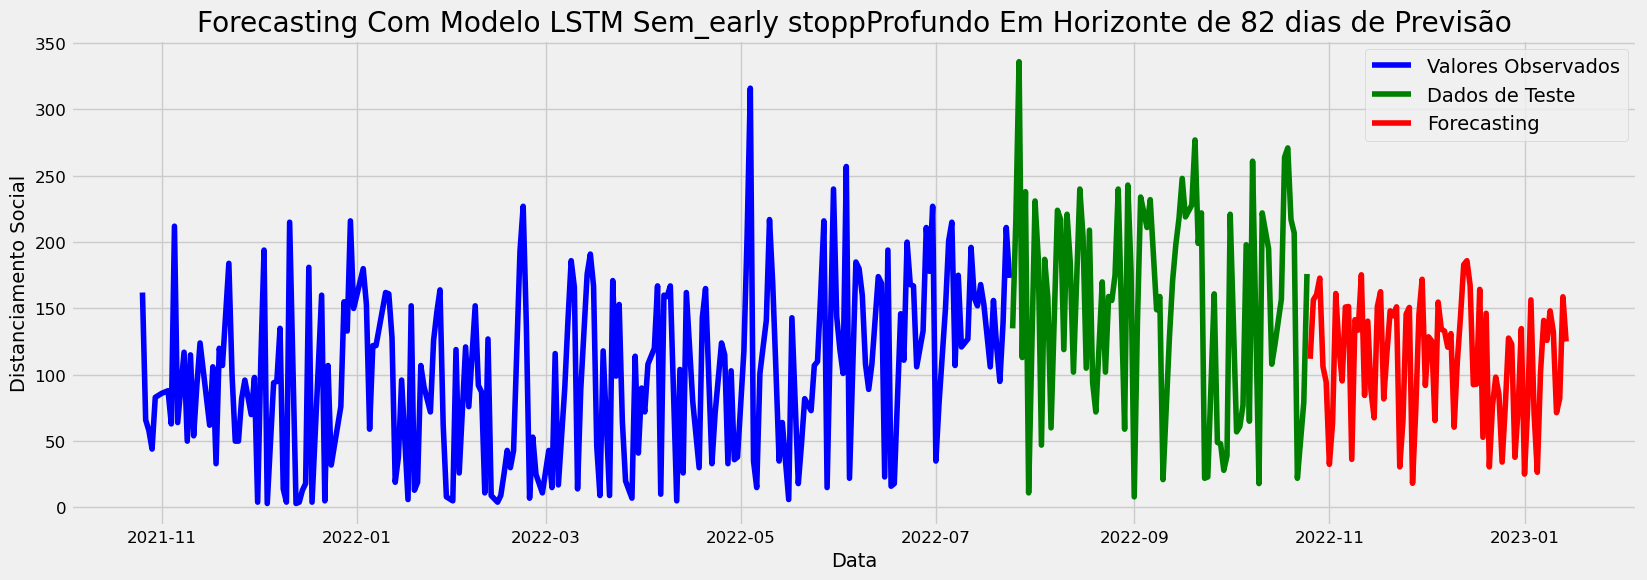

In [64]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Sem_early stoppProfundo Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim